<a href="https://colab.research.google.com/github/KayvanShah1/usc-dsci-552-lab-assignments-hw/blob/main/assignment-5/Kayvan_Shah_Assignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing & Importing required Modules & Libraries

In [2]:
!pip install ipython-autotime
%matplotlib inline
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.6 MB/s eta 0:00:00
time: 336 µs (started: 2023-04-03 06:04:55 +00:00)


In [3]:
from pprint import pprint

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.metrics import classification_report

import tensorflow as tf

time: 4.62 s (started: 2023-04-03 06:04:55 +00:00)


# TPU Configuration

In [4]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.85.248.106:8470
REPLICAS:  8
time: 12.9 s (started: 2023-04-03 06:04:59 +00:00)


# Data Preparation

In [5]:
# Load data
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()

# Train, Validation & Test Split
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

# Scale the Dataset
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

4422102/4422102 [==============================] - 0s 0us/step
time: 3.4 s (started: 2023-04-03 06:05:12 +00:00)


# Exploratory Data Analysis

In [6]:
print("Train size:", X_train.shape)
print("Validation size:", X_valid.shape)
print("Test size:", X_test.shape)

Train size: (55000, 28, 28)
Validation size: (5000, 28, 28)
Test size: (10000, 28, 28)
time: 4.02 ms (started: 2023-04-03 06:05:16 +00:00)


In [7]:
class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 
    'Dress', 'Coat','Sandal', 'Shirt', 
    'Sneaker', 'Bag', 'Ankle boot'
]

time: 620 µs (started: 2023-04-03 06:05:16 +00:00)


In [8]:
def plot_mnist_data(num_row = 3, num_col = 5):
    # get a segment of the dataset
    num = num_row*num_col
    images = X_train[:num]
    labels = y_train[:num]

    # plot images
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.25*num_col,1.25*num_row))
    for i in range(num_row*num_col):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(images[i])
        ax.set_title('Label: {}'.format(class_names[labels[i]]), fontsize=8)
    plt.tight_layout()
    plt.show()

time: 5.4 ms (started: 2023-04-03 06:05:16 +00:00)


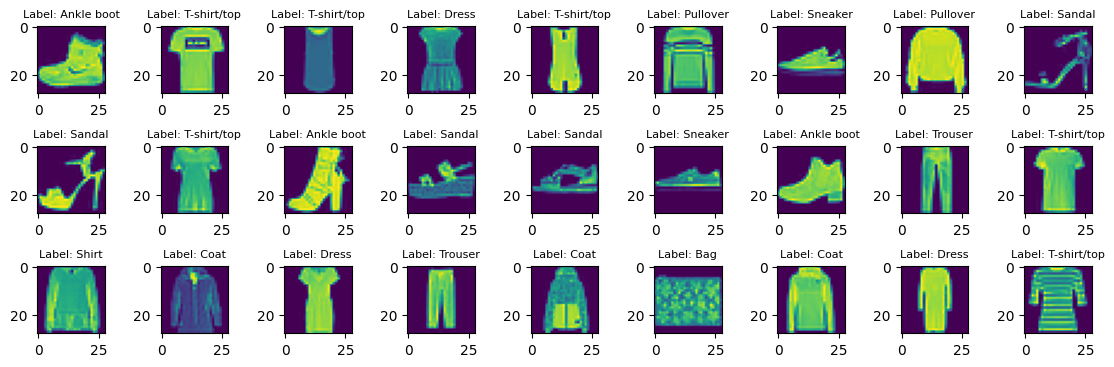

time: 11.3 s (started: 2023-04-03 06:05:16 +00:00)


In [9]:
plot_mnist_data(num_row = 3, num_col = 9)

# Converting to Tensorflow dataset

In [10]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

time: 666 µs (started: 2023-04-03 06:05:27 +00:00)


In [11]:
train = (
    tf.data.Dataset
    .from_tensor_slices((X_train, y_train))
    .repeat()
    .shuffle(128)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid = (
    tf.data.Dataset
    .from_tensor_slices((X_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    # .repeat()
    .shuffle(64)
    .prefetch(AUTO)
)

test = (
    tf.data.Dataset
    .from_tensor_slices((X_test, y_test))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

time: 7.64 s (started: 2023-04-03 06:05:27 +00:00)


# Train Models

## Part One

### Fashion MNIST Neural Network
Follow the instructions in Chapter 10 of Aurelien (Hands-on Machine Learning) to create a fourlayer neural network (1 Flatten Layer and 3 Dense Layers) and train it on the Fashion MNIST
dataset.

What to turn in:
- The CPU Times and Wall Times returned by fit() from the training process
- Generate loss and accuracy versus epoch plots (see Figure 10-11)
- The accuracy, precision and recall on the test test
- The precision and recall values by class_id on the test test. There are 10 classes.

### Build Model

In [14]:
def build_basic_model():
    tf.random.set_seed(42)
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(300, activation="relu"),
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])
    
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer="sgd",
        metrics=[tf.keras.metrics.sparse_categorical_accuracy]
    )
    return model

time: 932 µs (started: 2023-04-03 06:06:54 +00:00)


In [15]:
# Clear backend sessions to reset name counters
tf.keras.backend.clear_session()

with strategy.scope():
    model = build_basic_model()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________
time: 269 ms (started: 2023-04-03 06:06:56 +00:00)


### Train Model

In [16]:
EPOCHS = 50

n_steps = X_train.shape[0] // BATCH_SIZE

time: 640 µs (started: 2023-04-03 06:07:52 +00:00)


In [17]:
%%time
train_history = model.fit(
    train,
    steps_per_epoch=n_steps,
    validation_data=valid,
    epochs=EPOCHS
)

Epoch 1/50
429/429 [==============================] - 11s 20ms/step - loss: 1.0817 - sparse_categorical_accuracy: 0.6757 - val_loss: 0.7024 - val_sparse_categorical_accuracy: 0.7718
Epoch 2/50
429/429 [==============================] - 8s 19ms/step - loss: 0.6432 - sparse_categorical_accuracy: 0.7903 - val_loss: 0.5739 - val_sparse_categorical_accuracy: 0.8100
Epoch 3/50
429/429 [==============================] - 8s 18ms/step - loss: 0.5583 - sparse_categorical_accuracy: 0.8127 - val_loss: 0.5188 - val_sparse_categorical_accuracy: 0.8224
Epoch 4/50
429/429 [==============================] - 8s 18ms/step - loss: 0.5159 - sparse_categorical_accuracy: 0.8250 - val_loss: 0.4940 - val_sparse_categorical_accuracy: 0.8298
Epoch 5/50
429/429 [==============================] - 7s 17ms/step - loss: 0.4902 - sparse_categorical_accuracy: 0.8333 - val_loss: 0.4818 - val_sparse_categorical_accuracy: 0.8314
Epoch 6/50
429/429 [==============================] - 8s 18ms/step - loss: 0.4723 - sparse_cat

### Evaluate Model

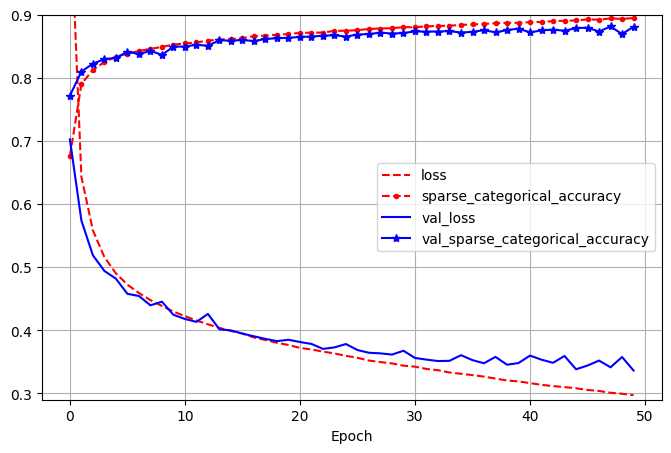

time: 510 ms (started: 2023-04-03 06:16:21 +00:00)


In [27]:
pd.DataFrame(train_history.history).plot(
    figsize=(8, 5), ylim=[0.29, 0.9], 
    grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"],
)
plt.show()

In [28]:
model.evaluate(test)

79/79 [==============================] - 3s 21ms/step - loss: 0.3582 - sparse_categorical_accuracy: 0.8730


[0.3581647276878357, 0.8730000257492065]

time: 3.54 s (started: 2023-04-03 06:16:31 +00:00)


In [29]:
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)

print(classification_report(y_test, y_pred, target_names=class_names))

313/313 [==============================] - 4s 9ms/step
              precision    recall  f1-score   support

 T-shirt/top       0.84      0.79      0.82      1000
     Trouser       0.98      0.97      0.98      1000
    Pullover       0.80      0.78      0.79      1000
       Dress       0.85      0.90      0.87      1000
        Coat       0.81      0.78      0.79      1000
      Sandal       0.96      0.95      0.96      1000
       Shirt       0.67      0.70      0.69      1000
     Sneaker       0.92      0.95      0.93      1000
         Bag       0.95      0.96      0.96      1000
  Ankle boot       0.96      0.95      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

time: 4.59 s (started: 2023-04-03 06:16:41 +00:00)


## Part 2

### Fashion MNIST Convolutional Neural Network
Repeat part problem 2, but this time create a convolution neural network using the Fashion
MNIST network in Chapter 14 of Aurelien.

### Build Model

In [30]:
from functools import partial

def build_cnn_model():
    DefaultConv2D = partial(
        tf.keras.layers.Conv2D, 
        kernel_size=3, 
        padding="same",
        activation="relu", 
        kernel_initializer="he_normal"
    )
    
    model = tf.keras.Sequential([
        DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
        tf.keras.layers.MaxPool2D(),
        DefaultConv2D(filters=128),
        DefaultConv2D(filters=128),
        tf.keras.layers.MaxPool2D(),
        DefaultConv2D(filters=256),
        DefaultConv2D(filters=256),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(
            units=128, activation="relu", kernel_initializer="he_normal"
        ),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(
            units=64, activation="relu", kernel_initializer="he_normal"
        ),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(units=10, activation="softmax")
    ])
    
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer="adam",
        metrics=[tf.keras.metrics.sparse_categorical_accuracy]
    )
    return model

time: 1.33 ms (started: 2023-04-03 06:16:53 +00:00)


In [36]:
# Clear backend sessions to reset name counters
tf.keras.backend.clear_session()

with strategy.scope():
    model_cnn = build_cnn_model()

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        3200      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 128)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 256)         2

### Train Model

In [37]:
EPOCHS = 9

n_steps = X_train.shape[0] // BATCH_SIZE

time: 667 µs (started: 2023-04-03 06:20:23 +00:00)


In [38]:
%%time
train_history_cnn = model_cnn.fit(
    train,
    steps_per_epoch=n_steps,
    validation_data=valid,
    epochs=EPOCHS
)

Epoch 1/9
429/429 [==============================] - 16s 23ms/step - loss: 1.2032 - sparse_categorical_accuracy: 0.5415 - val_loss: 0.5128 - val_sparse_categorical_accuracy: 0.8316
Epoch 2/9
429/429 [==============================] - 8s 19ms/step - loss: 0.6471 - sparse_categorical_accuracy: 0.7616 - val_loss: 0.4206 - val_sparse_categorical_accuracy: 0.8588
Epoch 3/9
429/429 [==============================] - 9s 20ms/step - loss: 0.4790 - sparse_categorical_accuracy: 0.8361 - val_loss: 0.3287 - val_sparse_categorical_accuracy: 0.8826
Epoch 4/9
429/429 [==============================] - 9s 20ms/step - loss: 0.3973 - sparse_categorical_accuracy: 0.8668 - val_loss: 0.2917 - val_sparse_categorical_accuracy: 0.8994
Epoch 5/9
429/429 [==============================] - 8s 20ms/step - loss: 0.3448 - sparse_categorical_accuracy: 0.8852 - val_loss: 0.2751 - val_sparse_categorical_accuracy: 0.9056
Epoch 6/9
429/429 [==============================] - 9s 21ms/step - loss: 0.3075 - sparse_categoric

### Evaluate Model

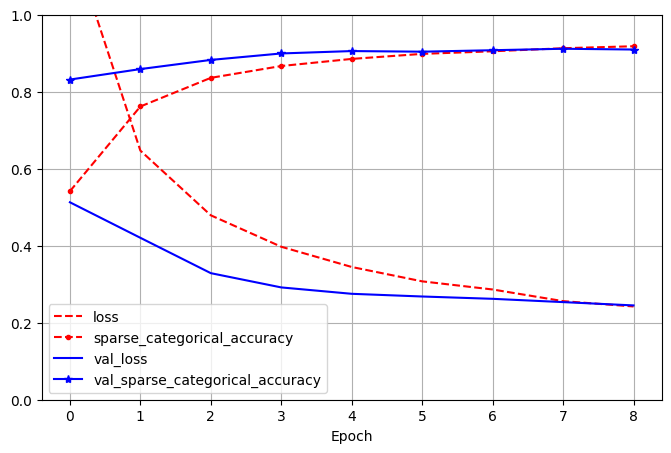

time: 282 ms (started: 2023-04-03 06:21:57 +00:00)


In [39]:
pd.DataFrame(train_history_cnn.history).plot(
    figsize=(8, 5), ylim=[0, 1], 
    grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"],
)
plt.show()

In [40]:
model_cnn.evaluate(test)

79/79 [==============================] - 2s 16ms/step - loss: 0.2616 - sparse_categorical_accuracy: 0.9157


[0.26163095235824585, 0.9157000184059143]

time: 2.48 s (started: 2023-04-03 06:22:08 +00:00)


In [41]:
y_pred = model_cnn.predict(X_test)
y_pred = y_pred.argmax(axis=-1)

print(classification_report(y_test, y_pred, target_names=class_names))

313/313 [==============================] - 6s 15ms/step
              precision    recall  f1-score   support

 T-shirt/top       0.89      0.83      0.86      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.84      0.89      0.86      1000
       Dress       0.94      0.90      0.92      1000
        Coat       0.84      0.89      0.86      1000
      Sandal       0.98      0.99      0.99      1000
       Shirt       0.75      0.75      0.75      1000
     Sneaker       0.97      0.97      0.97      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.98      0.97      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

time: 6.92 s (started: 2023-04-03 06:22:13 +00:00)


# References
[1] [Jigsaw Multilingual Toxic Comment Classification - Roberta-large-2](https://www.kaggle.com/code/kayvanshah/roberta-large-2)